In [ ]:
%load_ext autoreload
%autoreload 2

# Using scDALI - Example on synthetic data

In this example we will generate artificial data, test for dependencies and approximate the DALI generative model to estimate the allelic rates for each cell.

In [ ]:
import sys
sys.path.insert(0, '..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scdali import run_scdali
from scdali.utils import simulate
from scdali.utils.stats import apply_fdr_bh, compute_quantile_diff

## Data simulation

We start by simulating a cell state matrix. The cell state definition depends on the application and could be a pseudo-temporal ordering, a clustering of cell types or a lower-dimensional representation of non-allele-specific counts.

For this toy example we assume a one-dimensional cell state. The latent rates will be sampled from a Gaussian process with RBF kernel matrix.

In [5]:
n_cells = 500
n_regions = 25

In [6]:
cell_state = np.linspace(0, 1, n_cells)
K = simulate.create_rbf_kernel(cell_state, lengthscale=.8) + 1e-9 * np.eye(n_cells)

Simulate total counts from a Poisson model.

In [7]:
D = np.random.default_rng(123).poisson(lam=5, size=(cell_state.shape[0], n_regions))

We now draw from the scDALI model, a Gaussian process model with Beta-Binomial likelihood. The generative model for each region is as follows:

(1) Sample the cell-state dependent allelic rate from a Gaussian process with cell-state kernel $K$: 

\begin{equation}
g^{-1}(r^{cellstate})\sim\mathcal{N}(\mathbf{1}\alpha, \sigma^2_{het}K),
\end{equation}

where $g$ is the logit link function and $\sigma^2_{het}>0$ indicates cell-state-specific (heterogeneous) allelic imbalance.

(2) Sample from a Beta distribution with mean $r^{cellstate}$ and overdispersion parameter $\theta$: 
    
\begin{equation}
r^{binomial}_{i}\sim \text{Beta}(r^{cellstate}_i\theta^{-1}, (1-r^{cellstate}_i)\theta^{-1}),
\end{equation}

(3) Given total counts $d_i$ for cell $i$, sample alternative counts from a binomial model:
  
\begin{equation}
a_i\sim\text{Bin}(d_i, r^{binomial}_i).
\end{equation}

As a result, $a_i\,|\,d_i, r^{cellstate}_i$ follows a Beta-Binomial distribution which captures extra-binomial variance (overdispersion). Overdispersion is common in practice, as there are usually additional unmodelled technical and biological factors that affect the distribution of allelic rates in each cell.

In [8]:
sim = simulate.simulate_beta_binomial(K=K, D=D, sigma2=.5, theta=.1, mu=.01, seed=123)
A = sim['A']

Let's look at an example.

<ipython-input-9-3c111f4ce156>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(cell_state, A[:, 0] / D[:, 0], label='Empirical rate', c='k', s=3)


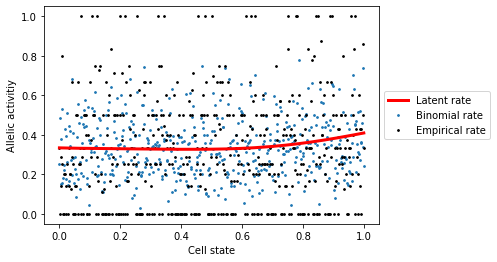

In [9]:
fig, ax = plt.subplots()
ax.plot(cell_state, sim['beta_mean'][:, 0], label='Latent rate', c='r', linewidth=3)
ax.scatter(cell_state, sim['binomial_mean'][:, 0], label='Binomial rate', s=3)
ax.scatter(cell_state, A[:, 0] / D[:, 0], label='Empirical rate', c='k', s=3)
ax.set(xlabel='Cell state', ylabel='Allelic activitiy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Testing

To test for allele-specific effects, scDALI offers a high-level interface. We will start by testing for heterogeneous effects, that is
\begin{equation}
\sigma^2_{het} > 0 \text{ vs. } \sigma^2_{het} = 0.
\end{equation}

In [10]:
pvals_het = run_scdali(A=A, D=D, cell_state=cell_state, model='scDALI-Het')['pvalues']

[scdali] Processing 25 regions on 1 core(s) ... 


100%|██████████| 25/25 [00:00<00:00, 29.27it/s]


scDALI also offers a joint test, where for a given base allelic rate $\alpha$ we can test if there is global allelic imbalance and/or cell-state specific effects. In this case $\alpha$ is fixed and we introduce another random effect distributed according to $\mathcal{N}(0, \sigma^2_{hom}\mathbf{1}\mathbf{1}^T)$, such that 

\begin{equation}
g^{-1}(r^{cellstate})\sim\mathcal{N}(\mathbf{1}\alpha, \sigma^2_{total}(\rho\mathbf{1}\mathbf{1}^T + (1-\rho) K)),
\end{equation}

where $\rho=\sigma_{hom}/\sigma_{total}$ is the fraction of allelic variance explained by global effects, $\sigma^2_{total} = \sigma^2_{het} + \sigma^2_{hom}$ and we test $\sigma^2_{total} > 0$.

In [11]:
res_joint = run_scdali(A=A, D=D, cell_state=cell_state, model='scDALI-Joint', return_rho=True, base_rate=.5)

[scdali] Processing 25 regions on 1 core(s) ... 


  0%|          | 0/25 [00:00<?, ?it/s]/Users/tobi/miniconda3/envs/dali/lib/python3.8/site-packages/chiscore/_optimal.py:166: RuntimeWarning: divide by zero encountered in true_divide
  temp = (pmin_q - temp1) / (1 - r_all)
100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


If we only want to test for pervasive (homogeneous) allelic imbalance, we can use 'scDALI-Hom' (score test) or 'BB-LRT' (likelihood ratio test).

In [12]:
pvals_hom = run_scdali(A=A, D=D, model='scDALI-Hom', base_rate=.5)['pvalues']

[scdali] Processing 25 regions on 1 core(s) ... 


100%|██████████| 25/25 [00:01<00:00, 13.42it/s]


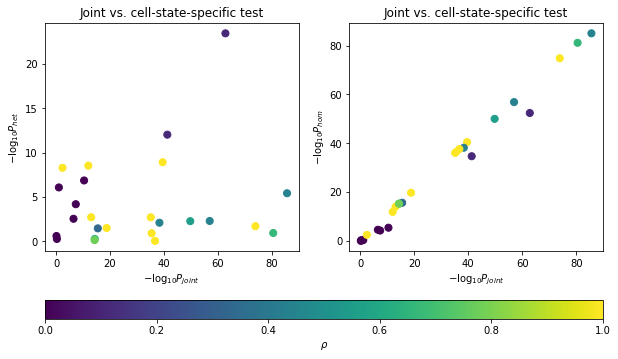

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes[0]
p = ax.scatter(-np.log10(res_joint['pvalues']), -np.log10(pvals_het), c=res_joint['rhos'], vmin=0, vmax=1, s=50)
ax.set(ylabel=r'$-\log_{10} P_{het}$', xlabel=r'$-\log_{10} P_{joint}$', title='Joint vs. cell-state-specific test')

ax = axes[1]
p = ax.scatter(-np.log10(res_joint['pvalues']), -np.log10(pvals_hom), c=res_joint['rhos'], vmin=0, vmax=1, s=50)
ax.set(ylabel=r'$-\log_{10} P_{hom}$', xlabel=r'$-\log_{10} P_{joint}$', title='Joint vs. cell-state-specific test')

plt.colorbar(p, label=r'$\rho$', orientation='horizontal', ax=axes, aspect=30);

Apply Benjamini-Hochberg to control FDR.

In [14]:
pvals_corrected = apply_fdr_bh(pvals_het)

## Gaussian process downstream analysis

Having identified a set of significantly variable regions, we can infer the latent rates using a Gaussian process (GP) model. scDALI offers a wrapper around gpflow to train a sparse GP model. The estimated latent rates can be used for visualization and effect size computation.

In [15]:
significant = np.where(pvals_corrected < .1)[0]
significant

array([ 1,  2,  3,  4,  5,  6,  7, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22,
       24])

In [16]:
gp_results = run_scdali(
    A=A[:, significant],
    D=D[:, significant],
    cell_state=cell_state,
    model='GP'
)

[scdali] Processing 18 regions on 1 core(s) ... 


100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


Let's again look at an example.

In [17]:
i = 0
region = significant[i]

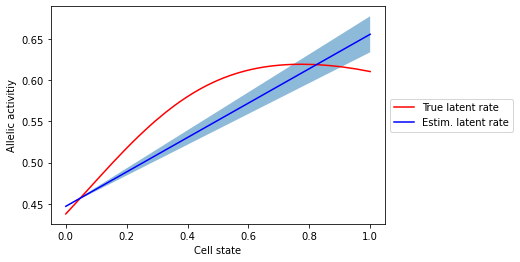

In [18]:
mu = gp_results['posterior_mean'][:, i]
sd = np.sqrt(gp_results['posterior_var'][:, i])

fig, ax = plt.subplots()
ax.plot(cell_state, sim['beta_mean'][:, region], label='True latent rate', c='r')
ax.plot(cell_state, mu, label='Estim. latent rate', c='b')
ax.fill_between(cell_state, mu-sd, mu+sd, alpha=.5)
ax.set(xlabel='Cell state', ylabel='Allelic activitiy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

To determine effect sizes, we compute the difference between the top and bottom quantiles for the estimated latent rates (Qdiff10)

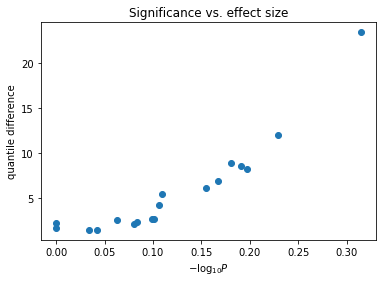

In [19]:
Qdiff10 = compute_quantile_diff(gp_results['posterior_mean'], .10)

fig, ax = plt.subplots()
ax.scatter(Qdiff10, -np.log10(pvals_het[significant]))
ax.set(xlabel=r'$-\log_{10} P$', ylabel='quantile difference', title='Significance vs. effect size');